<a href="https://colab.research.google.com/github/hamiin47/OB-session_M/blob/main/Assign_0310.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **chp.7 앙상블 학습과 랜덤 포레스트**

7.1 투표 기반 분류기



In [2]:
import warnings
warnings.filterwarnings('ignore')

#5장에서 소개한 moons dataset 불러오기

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X,y = make_moons(n_samples=100, noise=0.15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [4]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.9
RandomForestClassifier 1.0
SVC 1.0
VotingClassifier 1.0


투표 기반 분류기가 다른 개별 분류기보다 성능이 조금 더 높다.

7.2 배깅과 페이스팅

[다양한 분류기를 만드는 방법]
1. 각기 다른 훈련 알고리즘을 사용하는 방법
2. 깉은 알고리즘을 사용하고 훈련 세트의 서브셋을 무작위로 구성하여 분류기를 각기 다르게 학습시키는 방법
  - 이때 훈련 세트에서 중복을 허용하여 샘플링하는 방식을 배깅, 중복을 허용하지 않고 샘플링하는 방식을 페이스팅이라고 한다.
  - 배깅만이 한 예측기를 위해 같은 훈련 샘플을 여러번 샘플링할 수 있다.

7.2.1 사이킷런의 배깅과 페이스팅



In [7]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=50, bootstrap=True, n_jobs=-1)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

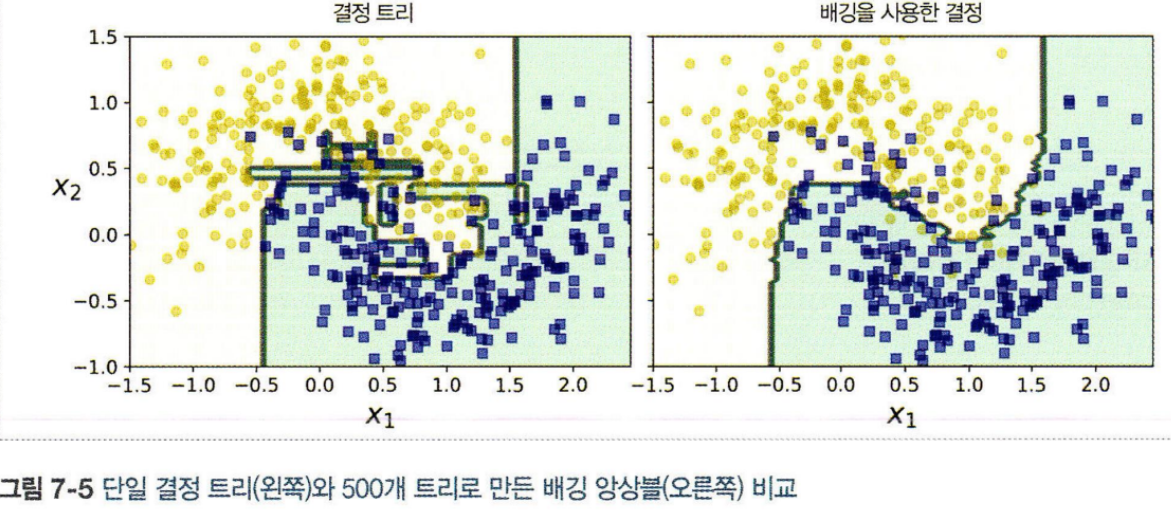

- 단일 결정 트리의 결정 경계와 500개의 트리를 사용한 배깅 앙상블의 결정 경계를 비교한 것이다.
- 그림에서 볼 수 있듯 앙상블의 예측이 결정 트리 하나의 예측보다 일반화가 훨씬 잘 되었다.
  - 앙상블은 비슷한 편향에서 더 작은 분산을 만든다.

7.2.2 oob 평가

- 배깅을 사용하면 어떤 샘플은 한 예측기를 위해 여러 번 샘플링되고 어떤 것은 전혀 선택되지 않을 수 있다.
- 예측기가 훈련되는 동안에는 oob 샘플을 사용하지 않으므로 별도의 검증 세트를 사용하지 않고 oob 샘플을 사용해 평가할 수 있다.
- 앙상블의 평가는 각 예측기의 oob 평가를 평균하여 얻는다.

In [8]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True)

In [9]:
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.95

In [10]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

1.0

In [11]:
bag_clf.oob_decision_function_

array([[0.        , 1.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.0952381 , 0.9047619 ],
       [0.67021277, 0.32978723],
       [0.60209424, 0.39790576],
       [0.65536723, 0.34463277],
       [0.97282609, 0.02717391],
       [1.        , 0.        ],
       [0.96276596, 0.03723404],
       [0.        , 1.        ],
       [0.20833333, 0.79166667],
       [0.59649123, 0.40350877],
       [0.36082474, 0.63917526],
       [0.25714286, 0.74285714],
       [0.        , 1.        ],
       [0.2826087 , 0.7173913 ],
       [0.01639344, 0.98360656],
       [0.21621622, 0.78378378],
       [0.07471264, 0.92528736],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.75      , 0.25      ],
       [0.        , 1.        ],
       [0.02247191, 0.97752809],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.08187135, 0.91812865],
       [0.54081633, 0.45918367],
       [0.

7.3 랜덤 패치와 랜덤 서브스페이스

- BaggingClassifier는 특성 샘플링도 지원한다.
- 샘플링은 max_features, bootstrap_features 두 매개변수로 조절된다.
- 작동 방식은 max_samples, bootstrap과 동일하지만 샘플이 아니고 특성에 대한 샘플링이다.

- 랜덤 패치 방식 : 훈련 특성과 샘플을 모두 샘플링하는 방식
- 랜덤 서브스페이스 방식 : 훈련 샘프을 모두 사용하고 특성은 샘플링하는 방식

7.4 랜덤 포레스트
- 일반적으로 배깅 방법을 적용한 결정 트리의 앙상블
- 전형적으로 max_samples를 훈련 세트의 크기로 지정한다.

In [12]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [13]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="auto", max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

7.4.1 엑스트라 트리
- 극단적으로 무작위한 트리의 랜덤 포레스트를 익스트림 랜덤 트리 앙상블이라고 부른다.
- 편향이 늘어나지만 분산을 낮추게 된다.

7.4.2 특성 중요도
- 랜덤 포레스트의 또 다른 장점은 특성의 상대적 중요도를 측정하기 쉽다는 것이다.

In [14]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.08961838580648615
sepal width (cm) 0.021300861664712015
petal length (cm) 0.456877055238226
petal width (cm) 0.43220369729057584


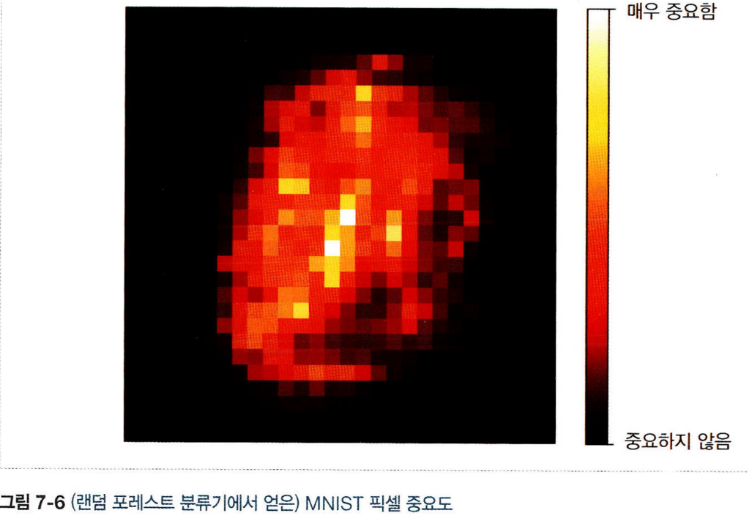

랜덤 포레스트는 특히 특성을 선택해야할 때 어떤 특성이 중요한지 빠르게 확인할다